In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ, Aer, QuantumCircuit, transpile
from qiskit.circuit import Gate
import qiskit.compiler.transpiler as transpiler
from qiskit.transpiler.passes import DynamicalDecoupling
from qiskit.circuit.library import XGate
from qiskit.tools.monitor import job_monitor
from qiskit_experiments.database_service import DbExperimentDataV1 as DbExperimentData

from rttgen import LinearizedCR, PulseEfficientCR, CNOTBasedRtt
from cx_decomposition import cx_circuit
from calibrations import MeasurementErrorMitigation, MeasurementErrorExperiment, LinearizedCRRabiExperiment
from model_circuits import single_step_no_opt, single_step, two_steps
from dynamics import plot_counts_with_curve

In [2]:
nsites = 4

J = 1. # Hamiltonian J parameter
mu = 2. # Hamiltonian mu parameter

M = 8 # number of Trotter steps
omegadt = 0.2 # Trotter step size

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research', group='tokyo-1', project='main')
backend = provider.get_backend('ibm_lagos')
physical_qubits = [1, 3, 5, 4]

In [4]:
# # ibmq_jakarta [1, 3, 5, 6]
# lcr_experiment_ids = {
#     (1, 3): '3c6fff4e-70d5-4213-b35e-806889a6ba5d',
#     (3, 5): '8226300a-4505-4c43-ab45-46edfd5ff890',
#     (5, 6): 'c749fb50-6422-45f1-8635-ad36afc4a636'
# }
# mem_experiment_id = 'bcd21c47-462b-495a-b56e-52fd3b963dac'

# ibmq_quito [2, 1, 3, 4]
#lcr_experiment_ids = {
#    (2, 1): '8b75a6fa-acfd-4c5f-a007-e01e0e8935b0',
#    (1, 3): '526741cb-15b8-435a-b96f-52fd473e5cc5',
#    (3, 4): '86c7660c-f1aa-4e90-bf69-83f8c5bb3764'
#}
#mem_experiment_id = '5195e012-c16b-46c7-8213-1e74e5e3303a'

# ibmq_manila [1, 2, 3, 4]
# lcr_experiment_ids = {
#     (1, 2): '52729ad1-4b92-4cbc-8fad-8917da958786',
#     (2, 3): 'a2daa511-2edd-4f3e-8842-3f8f78daeb19',
#     (3, 4): '7dd46c29-23a6-4468-b1e4-6682285ef7a0'
# }
# mem_experiment_id = 'bded0990-72d4-403c-b3ec-360afac64fc9'

#ibm_kawasaki 
# lcr_experiment_ids = {
#     (1, 2): '',
#     (2, 3): '',
#     (3, 4): ''
# }
# mem_experiment_id = ''

#ibm_lagos
lcr_experiment_ids = {
    (1, 3): 'a89e1fc4-3099-4004-92a6-b899002c696c',
    (3, 5): '7d08fb09-2ec7-49da-8151-ffc08acdc8bd',
    (5, 4): '76424e56-0d18-457d-8bd2-e2ba2363c3c7'
}
mem_experiment_id = '29dc9eee-dc71-489c-bf85-7bd0b941a696'

In [5]:
if not mem_experiment_id:
    exp = MeasurementErrorExperiment(physical_qubits, circuits_per_state=(backend.configuration().max_experiments // 32))
    exp_data = exp.run(backend=backend, shots=8192)
    print(exp_data.experiment_id)
    mem_experiment_id = exp_data.experiment_id
    exp_data.block_for_results()
    exp_data.save()

In [6]:
for qubits in zip(physical_qubits[:-1], physical_qubits[1:]):
    if not lcr_experiment_ids[tuple(qubits)]:
        exp = LinearizedCRRabiExperiment(qubits, backend)
        exp.circuits_per_point = backend.configuration().max_experiments // exp.width_values.shape[0] // 2
        exp_data = exp.run(backend=backend, shots=8192)
        print(exp_data.experiment_id)
        lcr_experiment_ids[tuple(qubits)] = exp_data.experiment_id
        exp_data.block_for_results()
        exp_data.save()

In [7]:
rtts_linear = {
    (0, 1): LinearizedCR(backend, tuple(physical_qubits[:2])),
    (1, 2): LinearizedCR(backend, tuple(physical_qubits[1:3])),
    (2, 3): LinearizedCR(backend, tuple(physical_qubits[2:]))
}
rtts_pe = {
    (0, 1): PulseEfficientCR(backend, tuple(physical_qubits[:2])),
    (1, 2): PulseEfficientCR(backend, tuple(physical_qubits[1:3])),
    (2, 3): PulseEfficientCR(backend, tuple(physical_qubits[2:]))
}
rtts_cnot = {
    (0, 1): CNOTBasedRtt(backend, tuple(physical_qubits[:2])),
    (1, 2): CNOTBasedRtt(backend, tuple(physical_qubits[1:3])),
    (2, 3): CNOTBasedRtt(backend, tuple(physical_qubits[2:]))
}

cxs = {
    (0, 1): cx_circuit(backend, *tuple(physical_qubits[:2])),
    (1, 0): cx_circuit(backend, *tuple(physical_qubits[1::-1]))
}
mem = MeasurementErrorMitigation(backend, physical_qubits)

for lcr in rtts_linear.values():
    if lcr.native_direction:
        qubits = (lcr.z_qubit, lcr.x_qubit)
    else:
        qubits = (lcr.x_qubit, lcr.z_qubit)

    lcr.load_calibration(lcr_experiment_ids[qubits])

mem.load_matrix(mem_experiment_id)

In [8]:
def trotter_step_circuits(backend, physical_qubits=None, rtts=None, cxs=None, optimization_level=1, with_dd=False):
    if rtts:
        single_step_circuit = single_step(nsites, J, mu, omegadt, rtts=rtts, cxs=cxs)
        two_step_circuit = two_steps(nsites, J, mu, omegadt, rtts=rtts, cxs=cxs)
    else:
        single_step_circuit = single_step_no_opt(nsites, J, mu, omegadt)
        two_step_circuit = single_step_circuit.compose(single_step_circuit)
    
    circuits = []
    for nrep in range(1, M + 1):
        circuit = QuantumCircuit(nsites, nsites)
        circuit.x(1)
        circuit.x(3)

        for _ in range(nrep // 2):
            circuit.compose(two_step_circuit, inplace=True)
                
        if nrep % 2 == 1:
            circuit.compose(single_step_circuit, inplace=True)
            
        circuit.measure(circuit.qregs[0], circuit.cregs[0])
        circuits.append(circuit)
        
    if with_dd:
        circuits = transpile_with_dynamical_decoupling(circuits, backend, physical_qubits, optimization_level=optimization_level)
    else:
        circuits = transpile(circuits, backend=backend, initial_layout=physical_qubits, optimization_level=optimization_level)
    circuits *= 2
    
    return circuits

In [9]:
from qiskit.transpiler.preset_passmanagers import level_0_pass_manager, level_1_pass_manager, level_2_pass_manager, level_3_pass_manager
preset_pms = [level_0_pass_manager, level_1_pass_manager, level_2_pass_manager, level_3_pass_manager]

def _transpile_circuit(circuit_config_tuple):
    circuit, transpile_config = circuit_config_tuple

    pass_manager_config = transpile_config["pass_manager_config"]

    # we choose an appropriate one based on desired optimization level
    level = transpile_config["optimization_level"]

    pass_manager = preset_pms[level](pass_manager_config)
    
    default_passes = pass_manager.passes()
    scheduling = default_passes[-2]['passes']
    dd = DynamicalDecoupling(pass_manager_config.instruction_durations, dd_sequence=[XGate(), XGate()])
    scheduling.append(dd)
    pass_manager.replace(-2, scheduling)

    result = pass_manager.run(
        circuit, callback=transpile_config["callback"], output_name=transpile_config["output_name"]
    )
    
    return result

def transpile_with_dynamical_decoupling(circuits, backend, initial_layout, optimization_level=1):
    transpile_args = transpiler._parse_transpile_args(
        circuits, # circuits,
        backend, # backend,
        None, # basis_gates,
        None, # coupling_map,
        None, # backend_properties,
        initial_layout, # initial_layout,
        None, # layout_method,
        None, # routing_method,
        None, # translation_method,
        'alap', # scheduling_method,
        None, # instruction_durations,
        None, # dt,
        None, # approximation_degree,
        None, # seed_transpiler,
        optimization_level, # optimization_level,
        None, # callback,
        None, # output_name,
        None  # timing_constraints,
    )

    transpiler._check_circuits_coupling_map(circuits, transpile_args, backend)

    # Transpile circuits in parallel
    return transpiler.parallel_map(_transpile_circuit, list(zip(circuits, transpile_args)))    

In [10]:
def combined_counts(job, exp_block_size):
    raw_counts = job.result().get_counts()
    counts = raw_counts[:exp_block_size]
    for iexp, cdict in enumerate(raw_counts[exp_block_size:]):
        ic = iexp % exp_block_size
        for key, value in cdict.items():
            try:
                counts[ic][key] += value
            except KeyError:
                counts[ic][key] = value
                
    return counts

def combined_and_corrected_counts(job, exp_block_size):
    counts = combined_counts(job, exp_block_size)
    return mem.apply(counts)

## Test on simulator

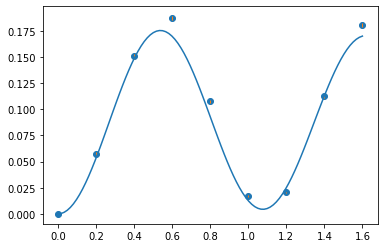

In [11]:
simulator = Aer.get_backend('qasm_simulator')
cx_sim = QuantumCircuit(2)
cx_sim.rz(np.pi / 2., 0)
cx_sim.x(0)
cx_sim.sx(1)
cx_sim.rzx(np.pi / 4., 0, 1)
cx_sim.x(0)
cx_sim.rzx(-np.pi / 4., 0, 1)
cxs_sim = {(0, 1): cx_sim, (1, 0): cx_sim}
circuits = trotter_step_circuits(simulator, rtts=rtts_cnot, cxs=cxs_sim, with_dd=False)
job_cnot_sim = simulator.run(circuits, shots=8192)
plot_counts_with_curve(combined_counts(job_cnot_sim, M), nsites, J, mu, omegadt, M)

## Define and submit all circuits

In [12]:
# circuits = trotter_step_circuits(backend, physical_qubits=physical_qubits, rtts=rtts_linear, cxs=cxs, with_dd=True)
# job_linear = backend.run(circuits, shots=8192)
# print('linear', job_linear.job_id())
job_linear = backend.retrieve_job('616f8757cea633cf53145082')

In [13]:
# circuits = trotter_step_circuits(backend, physical_qubits=physical_qubits, rtts=rtts_pe, cxs=cxs, with_dd=True)
# job_pe = backend.run(circuits, shots=8192)
# print('pe', job_pe.job_id())
job_pe = backend.retrieve_job('616f875c32bb43764da544ce')

In [14]:
# circuits = trotter_step_circuits(backend, physical_qubits=physical_qubits, optimization_level=3, with_dd=True)
# job_naive = backend.run(circuits, shots=8192)
# print('naive', job_naive.job_id())
job_naive = backend.retrieve_job('616f875f32bb437868a544cf')

In [15]:
# circuits = trotter_step_circuits(backend, physical_qubits=physical_qubits, rtts=rtts_cnot, with_dd=True)
# job_cnot = backend.run(circuits, shots=8192)
# print('cnot', job_cnot.job_id())
job_cnot = backend.retrieve_job('616f87631cc6818c439866a4')

## Forward steps with LinearizedCR

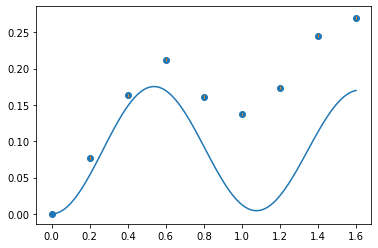

In [16]:
plot_counts_with_curve(combined_and_corrected_counts(job_linear, M), nsites, J, mu, omegadt, M)

## Forward steps with Pulse-Efficient CR

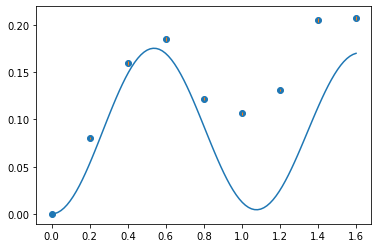

In [17]:
plot_counts_with_curve(combined_and_corrected_counts(job_pe, M), nsites, J, mu, omegadt, M)

## Forward with naive implementation (optimization level 3)

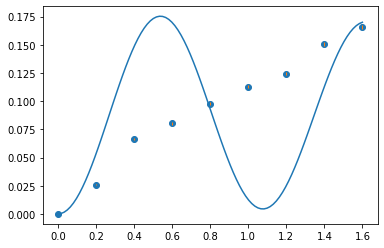

In [18]:
plot_counts_with_curve(combined_and_corrected_counts(job_naive, M), nsites, J, mu, omegadt, M)

## Forward steps with CNOT-based Rtt

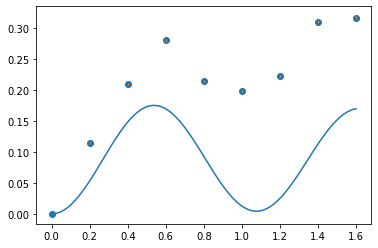

In [19]:
plot_counts_with_curve(combined_and_corrected_counts(job_cnot, M), nsites, J, mu, omegadt, M)